# Fitting a Stage-Discharge Rating
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/rating-function-uncertainty/blob/master/notebooks/segmented_power_law_demo.ipynb)  
This notebook demonstrates fitting a rating curve using a segmented power law.

The general form of the equation is:

\begin{align}
    log(Q) = a + \sum b_i\log(x - x_{o,i})H_i(x - x_{o,i})
\end{align}
where
$Q$ is discharge,  
$a$ and $b$ are model parameters,  
$x$ is stage,  
$x_{o,i}$ is the $i$th breakpoint, and  
$H$ is the Heaviside function.  
In a standard linear model $b$ represents the slope of the function with respect the input.
In the segmented power law $b_o$ is the slope and each subsequent $b_i$ are adjustment to the base slope for each segment.

In [30]:
# Only run this cell to setup Google Colab. It will take a minute.
%%capture
# Specific repo version used in this notebook
!pip install pymc==4.1.1

# Colab needs this
%env MKL_THREADING_LAYER=GNU

# install ratingcurve library
!pip install git+https://github.com/thodson-usgs/rating-function-uncertainty.git

SyntaxError: 'break' outside loop (3023007813.py, line 5)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import intake
import pymc as pm


from ratingcurve.ratingmodel import SegmentedRatingModel
from ratingcurve.plotting import plot_power_law_rating 

## Load Data

In [2]:
# load tutorial data
from ratingcurve import tutorial
tutorial.list_datasets()

['simulated_rating',
 'chalk_artificial',
 'provo_natural',
 'co_channel',
 'green_channel']

and load a specific dataset.

In [3]:
df = tutorial.open_dataset('green_channel')
df.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


Text(0, 0.5, 'Stage (ft)')

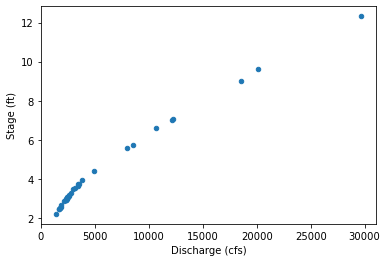

In [4]:
# plot the data
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)
q_sigma = df['q_sigma'].values.reshape(-1,1)

fig, ax = plt.subplots()
df.plot.scatter(x='q',y='stage', marker='o', ax=ax)
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

## Setup model
Setup a rating model. This make take a minute while the model compiles.

In [6]:
segments = 2
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   q_sigma = None, #not yet implemented
                                   prior = {'distribution':'uniform'})

then fit the model, here using variational inference.

In [7]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=150_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -44.908


Once fit, we can evaluate the model by plotting the rating curve.

/home/thodson/projects/uncertainty/rating-function-uncertainty/src/ratingcurve/plotting.py:101: RuntimeWarning: invalid value encountered in log
  b1 = np.where( h_tile <= hs, clips , np.log(h_tile-h0))


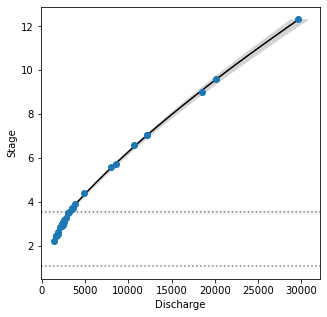

In [8]:
from ratingcurve.plotting import plot_power_law_rating 
plot_power_law_rating(powerrating,  trace, None)

or as a table of the parameters of the power-law model.

In [9]:
import arviz as az
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.317,0.005,1.308,1.327,0.000,0.0,5079.0,4782.0,NaN
w[1],0.392,0.007,0.379,0.406,0.000,0.0,4859.0,4613.0,NaN
a,-1.377,0.006,-1.387,-1.366,0.000,0.0,4966.0,4842.0,NaN
sigma,0.030,0.004,0.023,0.038,0.000,0.0,5181.0,4983.0,NaN
hs[0],1.078,0.009,1.062,1.095,0.000,0.0,5079.0,4744.0,NaN
hs[1],3.546,0.046,3.460,3.634,0.001,0.0,5132.0,4941.0,NaN


## Quiz
What happens if we choose the wrong number of segments? 
Increase the number of segments by one and rerun the model.

## Simulated Example
This example uses a simulated rating curve, which allows you to test how different sampling schemes affect the rating curve fit.

First, open the `simulated_rating` tutorial dataset.

In [10]:
sim_df = tutorial.open_dataset('simulated_rating')
print('The simulated rating contains {} observations'.format(len(sim_df)))

The simulated rating contains 763 observations


This rating contains observations of every 0.01 inch. increment in stage, which is much more than we'd have for a natural rating.
Try sampling to `n=15` or `n=30` and see how that affects the model fit.

Text(0, 0.5, 'Stage (ft)')

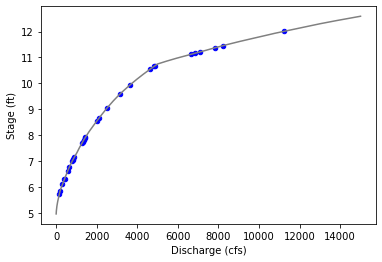

In [42]:
# subsample the simulated rating curve
n = 30
df = sim_df.sample(n)
df = df.sort_values(by='q') #XXX sort or plotting goes crazy
#fig, ax = plt.subplots()
h_obs = df['stage'].values.reshape(-1,1)
q_obs = df['q'].values.reshape(-1,1)

ax = sim_df.plot(x='q',y='stage', color='gray', ls='-', legend=False)
df.plot.scatter(x='q',y='stage', marker='o', color='blue', ax=ax)
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

Setup a rating model with 3 segments

In [43]:
segments = 3
powerrating = SegmentedRatingModel(q_obs, h_obs,  segments=segments,
                                   #q_sigma = q_sigma,
                                   q_sigma = None,
                                   prior = {'distribution':'uniform'})


now fit the model using ADVI

In [44]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=150_000) #increase n as necessary
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -46.653


and visualize the results.

In [ ]:
plot_power_law_rating(powerrating,  trace, None)

In [45]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.285,0.002,1.282,1.289,0.000,0.000,4809.0,4560.0,NaN
w[1],0.119,0.003,0.114,0.125,0.000,0.000,4690.0,5023.0,NaN
w[2],0.484,0.009,0.467,0.500,0.000,0.000,4786.0,4893.0,NaN
a,-1.452,0.002,-1.457,-1.448,0.000,0.000,5101.0,4671.0,NaN
sigma,0.011,0.002,0.008,0.014,0.000,0.000,4857.0,4648.0,NaN
hs[0],5.115,0.003,5.110,5.121,0.000,0.000,5113.0,4563.0,NaN
hs[1],8.390,0.063,8.275,8.507,0.001,0.001,4783.0,4577.0,NaN
hs[2],10.620,0.013,10.596,10.644,0.000,0.000,5177.0,4857.0,NaN


ADVI typically underestimates uncertainty; NUTS gives better results but will be slower for multiple segments.

In [48]:
# This may take several minutes
n = 4
with powerrating:
    trace = pm.sample(tune=1500, chains=n, cores=n, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs_, sigma]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 440 seconds.


ValueError: operands could not be broadcast together with shapes (50,1000,2) (2,1000,3) 

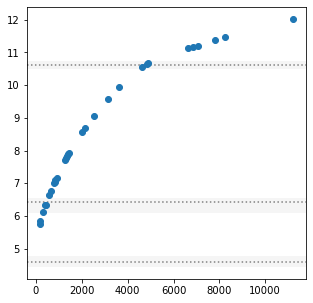

In [50]:
plot_power_law_rating(powerrating,  trace, None)

#  Notes
This notebook demonstrates the segmented power law. Sometimes other models may work better and another notebook will demonstrate fitting a natural spline rating.

Because of how USGS applies its rating models in practice, we are free to choose any model $f()$ for fitting a rating...


\begin{align}
q = f(\theta,s)
\end{align}

where f is the functional form of the rating: power law, spline, NN, etc.

This is because USGS doesn't use the rating model directly.
Instead the model is discritized to form a stage-rating lookup table

\begin{align}
d(f(\theta,s)) = \begin{bmatrix} s & \hat q \end{bmatrix}
\end{align}

We typically don't care how that table was generated,
we just want to know the predicted discharge for a given stage. 


1. To develop a rating, select a set of observations ($q_1$,$s_1$) and weights $w_1$, fit a rating model and  discritize to yield $\hat q_1$.

1. At a later point in time, develop a new rating from another (perhaps overlapping) set of observations ($q_2$, $s_2$, $w_2$) and discritize as $\hat q_2$.

1. As we accrue more ratings, we form a matrix $q_{ij}$, where $i$ is the rating and $j$ is the stage index. Flow at a particular time and stage ($t$,$s$) is estimated by interpolating between elements in this matrix.

1. After many ratings, we can apply Greg's approach to compute shift uncertainty at each stage $q_{,j}$.